In [2]:
import os
import random
import warnings
from prophet.plot import add_changepoints_to_plot, plot_seasonality
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import koreanize_matplotlib

warnings.filterwarnings(action='ignore')

Importing plotly failed. Interactive plots will not work.


In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


seed_everything(42)  # Seed 고정

In [29]:
info = pd.read_csv('./building_info.csv')
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [30]:
train_df

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40
...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,20220824 19,23.1,NaN,0.9,86.0,0.5,NaN,881.04
203996,100_20220824 20,100,20220824 20,22.4,NaN,1.3,86.0,0.0,NaN,798.96
203997,100_20220824 21,100,20220824 21,21.3,NaN,1.0,92.0,NaN,NaN,825.12
203998,100_20220824 22,100,20220824 22,21.0,NaN,0.3,94.0,NaN,NaN,640.08


## 가장 결과가 좋았던 외생변수 4종을 포함한 코드에 prameter 최적화를 수행한다

In [31]:
test_submission = pd.DataFrame(columns=['num_date_time', 'answer'])
fillzero_train = train_df.fillna(0)
holidays = pd.DataFrame(columns=['holiday', 'ds'])
def is_weekend(ds):
    date = pd.to_datetime(ds)
    if date.weekday() >= 5:
        return 1
    else:
        return 0
def is_noon(ds):
    date = pd.to_datetime(ds)
    if date.hour >= 7 and date.hour<20:
        return 1
    else:
        return 0
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100
test_target = test_df["num_date_time"].str.split("_").apply(lambda x: x[1])
test_df["num_date_time"] = pd.to_datetime(test_target, format="%Y%m%d %H")
test_data = test_df.rename(columns={'num_date_time': 'ds'})[
    ['ds', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)']].reset_index(drop=True)
test_data['weekend'] = test_data['ds'].apply(is_weekend)
test_data['noon'] = test_data['ds'].apply(is_noon)
test_data['weekend'] = test_data['ds'].apply(is_weekend)
test_data['noon'] = test_data['ds'].apply(is_noon)
for i in range(1, 101):
    # 한건물당 168개씩 예측한다
    sample_train = fillzero_train.loc[fillzero_train["건물번호"] == i]
    target = sample_train["num_date_time"].str.split("_").apply(lambda x: x[1])
    sample_train["num_date_time"] = pd.to_datetime(target, format="%Y%m%d %H")
    data = sample_train.rename(columns={'num_date_time': 'ds', "전력소비량(kWh)": 'y'})[
        ['ds', 'y', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)']].reset_index(drop=True)
    data['weekend'] = data['ds'].apply(is_weekend)
    data['noon'] = data['ds'].apply(is_noon)
    data['weekend'] = data['ds'].apply(is_weekend)
    data['noon'] = data['ds'].apply(is_noon)

    # sample_test = test_df.loc[test_df["건물번호"] == i]
    # target_test = sample_test["num_date_time"].str.split("_").apply(lambda x: x[1])
    # sample_test["num_date_time"] = pd.to_datetime(target_test, format="%Y%m%d %H")
    # data_test = sample_test.rename(columns={'num_date_time': 'ds', "전력소비량(kWh)": 'y'})[
    #     ['ds', 'y', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)']].reset_index(drop=True)
    # data_test['weekend'] = data_test['ds'].apply(is_weekend)
    # data_test['noon'] = data_test['ds'].apply(is_noon)
    # data_test['weekend'] = data_test['ds'].apply(is_weekend)
    # data_test['noon'] = data_test['ds'].apply(is_noon)
    # data['holidays'] = 0
    m = Prophet(
        # growth: Any = 'linear',
        #      changepoints: Any = None,
        #      n_changepoints: Any = 25,
             changepoint_range = 1,
        #      yearly_seasonality: Any = 'auto',
        #      weekly_seasonality: Any = 'auto',
        #      daily_seasonality: Any = 'auto',
             holidays = holidays,
        #      seasonality_mode: Any = 'additive',
        #      seasonality_prior_scale: Any = 10.0,
        #      holidays_prior_scale: Any = 10.0,
        #      changepoint_prior_scale = 0.01,
        #      mcmc_samples: Any = 0,
        #      interval_width: Any = 0.80,
        #      uncertainty_samples: Any = 1000,
        #      stan_backend: Any = None
    )
    m.add_seasonality(name='weekend', period=7, fourier_order=84, condition_name='weekend')
    m.add_seasonality(name='noon', period=1, fourier_order=84, condition_name='noon')
    m.add_country_holidays(country_name='KR')
    m.add_regressor('기온(C)')
    m.add_regressor('강수량(mm)')
    m.add_regressor('풍속(m/s)')
    m.add_regressor('습도(%)')
    m.fit(data)

    future = m.make_future_dataframe(periods=168, freq='1H')
    future['기온(C)'] = data['기온(C)']
    future['강수량(mm)'] = data['강수량(mm)']
    future['풍속(m/s)'] = data['풍속(m/s)']
    future['습도(%)'] = data['습도(%)']
    future['weekend'] = data['weekend']
    future['noon'] = data['noon']

    future.loc[future.shape[0] - 168:, '기온(C)'] = test_data.loc[(i - 1) * 168:i * 168 - 1, '기온(C)'].values
    future.loc[future.shape[0] - 168:, '강수량(mm)'] = test_data.loc[(i - 1) * 168:i * 168 - 1, '강수량(mm)'].values
    future.loc[future.shape[0] - 168:, '풍속(m/s)'] = test_data.loc[(i - 1) * 168:i * 168 - 1, '풍속(m/s)'].values
    future.loc[future.shape[0] - 168:, '습도(%)'] = test_data.loc[(i - 1) * 168:i * 168 - 1, '습도(%)'].values
    future.loc[future.shape[0] - 168:, 'weekend'] = test_data.loc[(i - 1) * 168:i * 168 - 1, 'weekend'].values
    future.loc[future.shape[0] - 168:, 'noon'] = test_data.loc[(i - 1) * 168:i * 168 - 1, 'noon'].values

    forecast = m.predict(future)

    answer = forecast[-168:].loc[:, ['ds', 'yhat']].rename(
        columns={"ds": "num_date_time", "yhat": "answer"}).reset_index(drop=True)

    answer["year"] = answer["num_date_time"].dt.year.astype(str)
    answer["month"] = answer["num_date_time"].dt.month.astype(str).str.zfill(2)
    answer["day"] = answer["num_date_time"].dt.day.astype(str).str.zfill(2)
    answer["hour"] = answer["num_date_time"].dt.hour.astype(str).str.zfill(2)
    answer["num_date_time"] = f"{i}_" + answer["year"] + answer["month"] + answer["day"] + ' ' + answer["hour"]
    test_submission = test_submission.append(answer)
test_submission = test_submission[["num_date_time", "answer"]]
test_submission.set_index("num_date_time", inplace=True)

12:29:06 - cmdstanpy - INFO - Chain [1] start processing
12:29:07 - cmdstanpy - INFO - Chain [1] done processing
12:29:08 - cmdstanpy - INFO - Chain [1] start processing
12:29:09 - cmdstanpy - INFO - Chain [1] done processing
12:29:10 - cmdstanpy - INFO - Chain [1] start processing
12:29:12 - cmdstanpy - INFO - Chain [1] done processing
12:29:13 - cmdstanpy - INFO - Chain [1] start processing
12:29:14 - cmdstanpy - INFO - Chain [1] done processing
12:29:15 - cmdstanpy - INFO - Chain [1] start processing
12:29:16 - cmdstanpy - INFO - Chain [1] done processing
12:29:17 - cmdstanpy - INFO - Chain [1] start processing
12:29:18 - cmdstanpy - INFO - Chain [1] done processing
12:29:19 - cmdstanpy - INFO - Chain [1] start processing
12:29:20 - cmdstanpy - INFO - Chain [1] done processing
12:29:21 - cmdstanpy - INFO - Chain [1] start processing
12:29:21 - cmdstanpy - INFO - Chain [1] done processing
12:29:23 - cmdstanpy - INFO - Chain [1] start processing
12:29:24 - cmdstanpy - INFO - Chain [1]

In [32]:
test_data

,ds,기온(C),강수량(mm),풍속(m/s),습도(%),weekend,noon
0,2022-08-25 00:00:00,23.5,0.0,2.2,72,0,0
1,2022-08-25 01:00:00,23.0,0.0,0.9,72,0,0
2,2022-08-25 02:00:00,22.7,0.0,1.5,75,0,0
3,2022-08-25 03:00:00,22.1,0.0,1.3,78,0,0
4,2022-08-25 04:00:00,21.8,0.0,1.0,77,0,0
...,...,...,...,...,...,...,...
16795,2022-08-31 19:00:00,22.5,0.0,0.9,84,0,1
16796,2022-08-31 20:00:00,20.7,0.0,0.4,95,0,0
16797,2022-08-31 21:00:00,20.2,0.0,0.4,98,0,0
16798,2022-08-31 22:00:00,20.1,0.0,1.1,97,0,0


In [39]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Alternative holiday of Chuseok,Alternative holiday of Chuseok_lower,Alternative holiday of Chuseok_upper,Alternative holiday of Hangeul Day,...,습도(%),습도(%)_lower,습도(%)_upper,풍속(m/s),풍속(m/s)_lower,풍속(m/s)_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-06-01 00:00:00,673.004880,197.736847,357.412183,673.004880,673.004880,0.0,0.0,0.0,0.0,...,0.560816,0.560816,0.560816,1.623234,1.623234,1.623234,0.0,0.0,0.0,276.879636
1,2022-06-01 01:00:00,672.860917,130.275006,301.081680,672.860917,672.860917,0.0,0.0,0.0,0.0,...,0.319126,0.319126,0.319126,1.913950,1.913950,1.913950,0.0,0.0,0.0,212.978667
2,2022-06-01 02:00:00,672.716954,116.871986,279.694855,672.716954,672.716954,0.0,0.0,0.0,0.0,...,0.222450,0.222450,0.222450,1.913950,1.913950,1.913950,0.0,0.0,0.0,197.176009
3,2022-06-01 03:00:00,672.572990,111.943718,272.395616,672.572990,672.572990,0.0,0.0,0.0,0.0,...,0.029098,0.029098,0.029098,1.768592,1.768592,1.768592,0.0,0.0,0.0,191.358985
4,2022-06-01 04:00:00,672.429027,105.156035,271.217228,672.429027,672.429027,0.0,0.0,0.0,0.0,...,0.125774,0.125774,0.125774,1.768592,1.768592,1.768592,0.0,0.0,0.0,185.083032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2203,2022-08-31 19:00:00,777.818894,876.125999,1050.857538,758.144489,794.196224,0.0,0.0,0.0,0.0,...,-0.115916,-0.115916,-0.115916,0.751087,0.751087,0.751087,0.0,0.0,0.0,963.477557
2204,2022-08-31 20:00:00,777.735385,784.863518,962.140517,757.828619,794.252286,0.0,0.0,0.0,0.0,...,-0.647634,-0.647634,-0.647634,1.477877,1.477877,1.477877,0.0,0.0,0.0,873.658404
2205,2022-08-31 21:00:00,777.651875,692.915006,860.452806,757.512750,794.314514,0.0,0.0,0.0,0.0,...,-0.792648,-0.792648,-0.792648,1.477877,1.477877,1.477877,0.0,0.0,0.0,779.048500
2206,2022-08-31 22:00:00,777.568365,583.787586,754.820168,757.196880,794.423745,0.0,0.0,0.0,0.0,...,-0.744310,-0.744310,-0.744310,0.460371,0.460371,0.460371,0.0,0.0,0.0,674.018964


In [34]:
m.train_holiday_names

0                                New Year's Day
1                          Lunar New Year's Day
2     The day preceding of Lunar New Year's Day
3        The second day of Lunar New Year's Day
4                     Independence Movement Day
5                        Birthday of the Buddha
6                                Children's Day
7                                    Labour Day
8                                  Memorial Day
9                                Liberation Day
10                                      Chuseok
11                 The day preceding of Chuseok
12                    The second day of Chuseok
13               Alternative holiday of Chuseok
14                      National Foundation Day
15                                  Hangeul Day
16           Alternative holiday of Hangeul Day
17                                Christmas Day
dtype: object

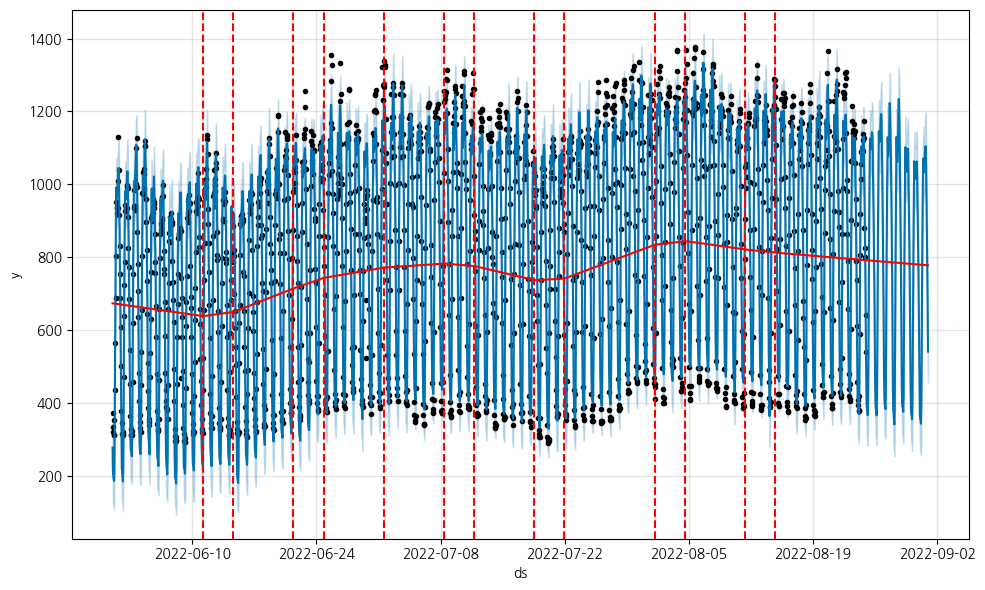

In [35]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

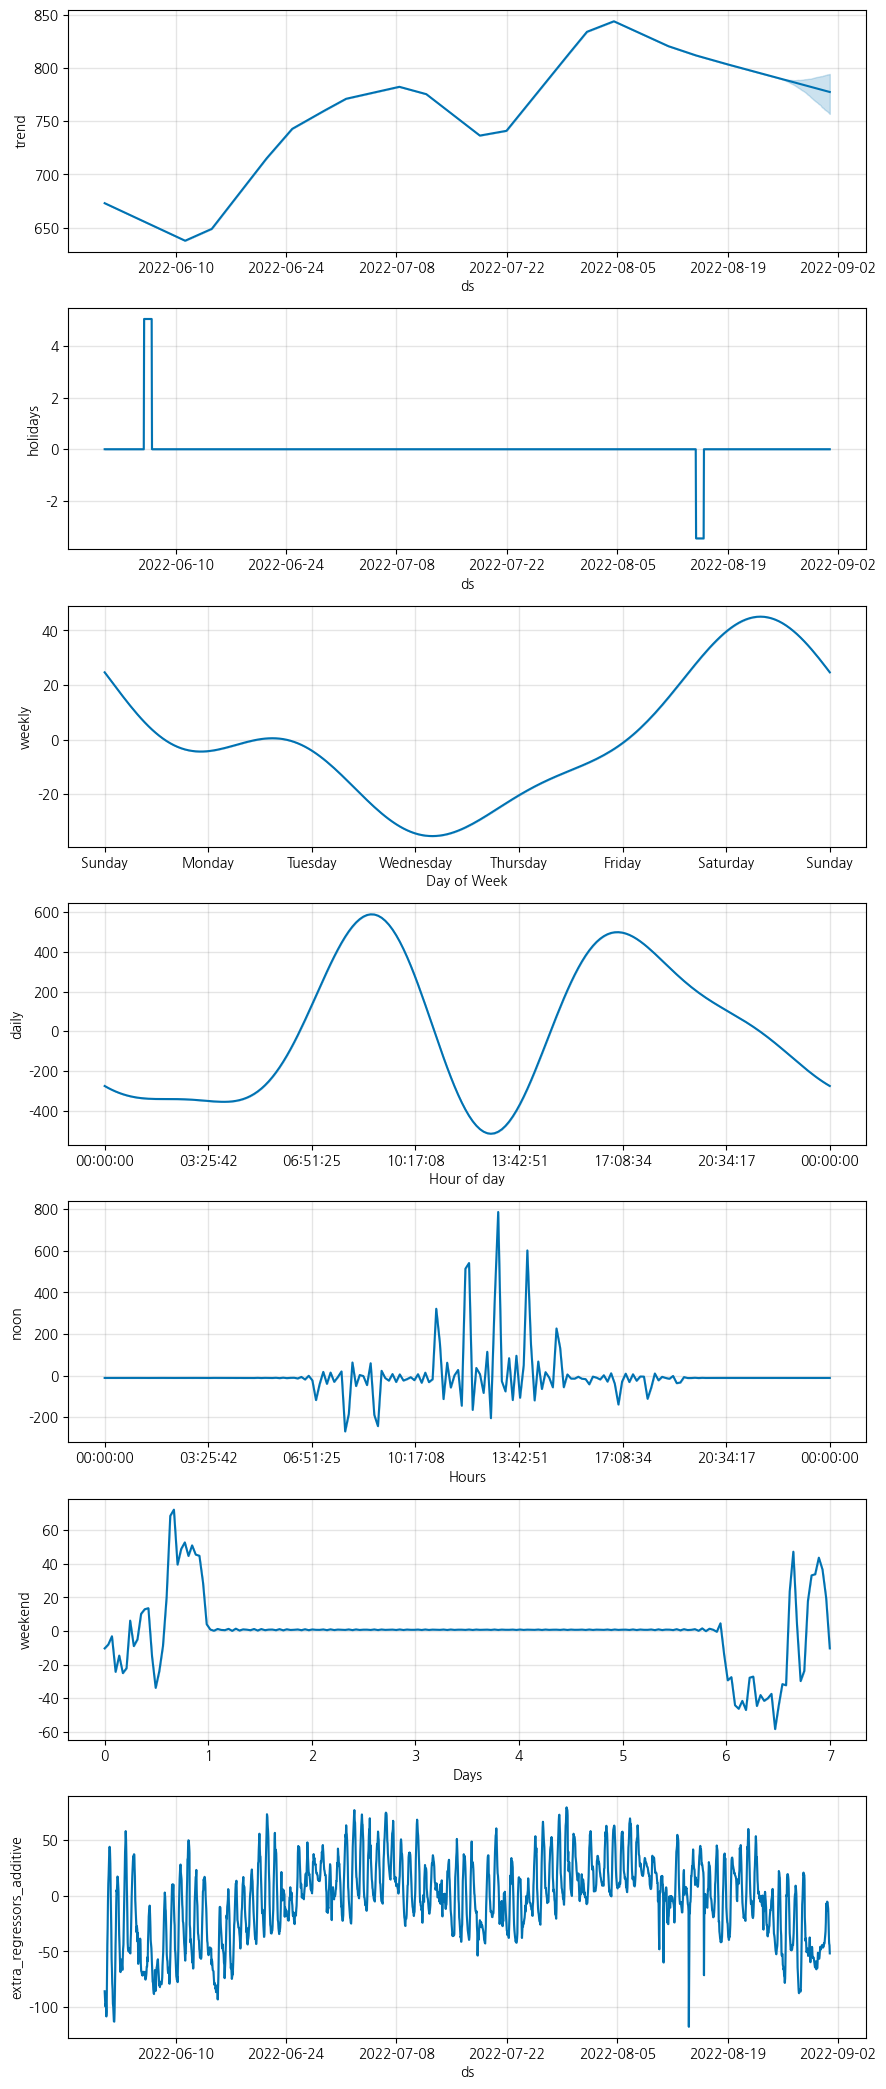

In [36]:
fig = m.plot_components(forecast)

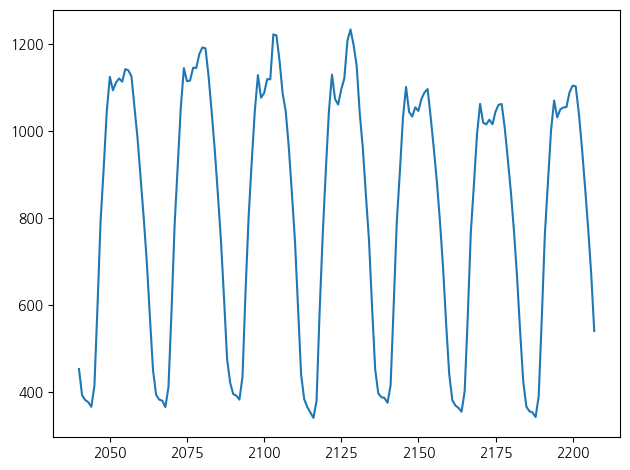

In [37]:
days = 2040
forecast.loc[days:, 'yhat'].plot()
# plt.xticks(ticks=range(0, days+1, 12), labels=forecast['ds'][:days+1:12].dt.strftime('%Y-%m-%d %H:%M'), rotation=45)
plt.tight_layout()
plt.show()

In [38]:
test_submission.to_csv("results/2023-08-15_re.csv")

## 제출결과
1. cap, floor 설정 및 logistic 분석 실시 : 11.6409051412(2023-08-13.csv)
2. 지난 최고점인 prophet linear모델에 holidays 추가 : 11.3840875952(2023-08-14_h.csv) 점수 상승
3. changepoint_range(과적합 방지용) = 0.95 : 11.3838344125(2023-08-14.csv) 점수 상승
4. changepoint_range(과적합 방지용) = 1 : 11.3809335269(2023-08-15.csv) 점수 상승
5. changepoint_prior_scale = 0.1 : 11.6773858778(2023-08-15_2.csv)
6. changepoint_prior_scale = 0.01 : 11.4329635772(2023-08-15_3.csv)
7. noon, weekend 데이터 추가 : 7.18263(2023-08-15_re.csv) 최고점